# Pricing with Rational Inattnetion: Mackowiak and Wiederholt (2009)

This notebook replicates [Mackowiak and Wiederholt (2009)](https://www.aeaweb.org/articles?id=10.1257/aer.99.3.769) (henceforth MW) using the methods and the [solver](https://github.com/choongryulyang/dynamic_multivariate_RI) from [Afrouzi and Yang (2019)](http://www.afrouzi.com/dynamic_inattention.pdf) that was adapted for Julia by [Miguel Acosta](https://www.acostamiguel.com/home). 

## Contents
* [Setup](#setup)
* [Mapping the Problem to a D.R.I.P.](#map_drip)
* [Initialization](#param)
* [Functions](#funcs)
    * [Solving for the fixed point given $\omega$](#fpointomega)
    * [Solving for the optimal $\omega$](#solveomega)
* [Figures](#figures)
    * [Benchmark Economy](#fig_benchmark)
    * [Other values of real rigidity](#robust_alpha)
    * [Other values of information capacity](#robust_kappa)
* [Measuring Performance/Speed](#performance)

## Setup <a class="anchor" id="setup"></a>

The problem in MW is 
\begin{align}
	&\min_{\{\hat{\Delta}_{i,t},\hat{z}_{i,t}\}} \left\{ E\left[(\Delta_t-\hat{\Delta}_{i,t})^2\right]+\underset{\equiv \xi}{\underbrace{\left(\frac{\hat{\pi}_{14}}{\hat{\pi}_{11}}\right)}}^2E\left[(z_{i,t}-\hat{z}_{i,t})^2\right]\right\}, \\
	s.t.\quad & \mathcal{I}(\{\Delta_t\};\{\hat{\Delta}_{i,t}\})+\mathcal{I}(\{z_{i,t}\};\{\hat{z}_{i,t}\})\leq \kappa, \tag{capacity constraint}\\
	& \{\Delta_t,\hat{\Delta}_{i,t}\} \perp \{z_{i,t},\hat{z}_{i,t}\} \tag{independence assumption}
\end{align}
where 
\begin{align}
    \Delta_t&\equiv p_t + \underset{\equiv 1-\alpha}{\underbrace{\left(\frac{|\hat{\pi}_{13}|}{|\hat{\pi}_{11}|}\right)}}(q_t-p_t) \\
    p_t &= \int_0^1 \hat{\Delta}_{i,t}di \\
    q_t &= \rho q_{t-1} + \nu_t, \nu_{q,t}\sim \mathcal{N}(0,\sigma_q^2) \\
    z_{i,t}&= \rho z_{i,t-1} + \nu_{z,t}, \nu_{z,t}\sim \mathcal{N}(0,\sigma_z^2)
\end{align}

## Mapping the Problem to a D.R.I.P. <a class="anchor" id="map_drip"></a>

There are a few ways of translating the problem above to a D.R.I.P. structure; however, the most efficient way, due to the independence assumption, is to write it as the sum of two D.R.I.P.'s: one that solves the attention problem for the idiosyncratic shock, and one that solves the attention problem for the aggregate shock which also has endogenous feedback.

Moreover, since the problem above has a fixed capacity, instead of a fixed cost of attention ($\omega$) as in D.R.I.P. pacakge, we need to iterate over $\omega$'s to find the one that corresponds with $\kappa$.

## Initialization <a class="anchor" id="param"></a>
Include the solver and import packages:

In [1]:
include("DRIP.jl");
using Printf, Plots, LaTeXStrings, BenchmarkTools; pyplot();

Set parameters:

In [2]:
## Parameters 
ρ  = 0.95;
σq = 0.01; 
σz = 11.8*σq;
κ  = 3;
ξ  = 1; 
α  = 1 - 0.15;

## Primitives of drip
L  = 21; # length of trunction
A  = [zeros(1,L);[Matrix(I,L-1,L-1);zeros(1,L-1)]']; # MW truncate the state space with linear irfs of length 20
Qq = zeros(L,1); Qq[1]=σq;
Qz = zeros(L,1); Qz[1]=σz;
H  = zeros(L,1); H[1:21] = Array(1:-1/20:0);

## Functions <a class="anchor" id="funcs"></a>
We start with a function that solves the aggregate problem with feedback for a given $\omega$.
### Solving for the fixed point given $\omega$ <a class="anchor" id="fpointomega"></a>

In [3]:
function agg_drip(ω,A,Qq,        #primitives of drip except for H because H is endogenous
                  α,             #strategic complementarity
                  H;             #state space rep. of q
                  β     = 1,     #optional: discount factor, MW's parameterization implies β = 1
                  H0    = H,     #optional: initial guess for HΔ (H is the true solution when α=0)
                  maxit = 10000, #optional: max number of iterations for GE code 
                  tol   = 1e-4,  #optional: tolerance for iterations 
                  w     = 1)     #optional: update weight for RI
    # set primitives
    errmin= 1;
    err   = 1;  
    iter  = 0;
    L     = length(H);
    while (err > tol) & (iter < maxit)
            if iter == 0 
                global agg  = solve_drip(ω,β,A,Qq,H0;w = w); 
            else 
                global agg  = solve_drip(ω,β,A,Qq,H0;Ω0 = agg.Ω , Σ0 = agg.Σ_1,w = w);
            end

            XFUN(jj) = ((I-agg.K*agg.Y')*agg.A)^jj * (agg.K*agg.Y') * (agg.A')^jj
            X = infinitesum(XFUN; maxit=200, start = 0);  #E[x⃗]=X×x⃗

            XpFUN(jj) = α^jj * X^(jj)
            Xp = infinitesum(XpFUN; maxit=200, start = 0);

            H1 = (1-α)*Xp'*H;
            
            err= 0.5*norm(H1-H0,2)/norm(H0)+0.5*err;
            if capacity(agg) < 1e-2
                H0 = 0.9*H0+0.1*rand(L);
            else
                H0 = H1;
                if err < errmin
                    global aggmin = agg;
                    errmin = err;
                end
            end
            iter += 1;
    end
    return(aggmin)
end;

Now we need a function that iterates over $\omega$'s to find the one that corresponds to a given capacity for the MW problem.
### Solving for the optimal $\omega$ <a class="anchor" id="solveomega"></a>

In [4]:
function MW(κ,α,A,Qq,Qz,Hq,Hz; #primitives of MW problem
            ω     = σq^2,      #optional: initial guess for ω
            tol   = 1e-3,      #optional: tolerance for κ
            maxit = 10000)     #optional: max iterations
    ωs    = [ω; 2*ω];
    caps  = [];
    iter  = 0;
    err   = 1;
    it    = 0;
    while (err > tol) & (iter < maxit)
        agg = agg_drip(ω,A,Qq,α,H; H0 = rand(L),maxit=20,w=0.95);
        idi = solve_drip(ω,1,A,Qz,H,w = 0.9) ;
        cap = capacity(agg, unit = "bit") + capacity(idi, unit = "bit");
        x = ω/σq^2;
        @printf("ω = %.2fσq² for κ = %.2f \n",x,cap)
        push!(caps,cap);
        if it == 0
            ω = ωs[end];
        else
            slope = (caps[end]-caps[end-1])/(ωs[end]-ωs[end-1]);
            ω     = ω + (κ-caps[end])/slope;
            push!(ωs,ω);
        end
        err = abs(caps[end] - κ)/κ;
        it  += 1;
    end
    return(ω);
end;

## Figures <a class="anchor" id="figures"></a>
Start with the benchmark calibration:
### Benchmark Economy <a class="anchor" id="fig_benchmark"></a>

In [5]:
ω    = MW(3,α,A,Qq,Qz,H,H);
agg  = agg_drip(ω,A,Qq,α,H; H0 = rand(L), maxit = 500, w = 0.95);
idi  = solve_drip(ω,1,A,Qz,H,w = 0.9);
@printf("Agg. Capacity = %.2f bits, Idio. Capacity = %.2f bits",capacity(agg),capacity(idi));

ω = 1.00σq² for κ = 3.79 
ω = 2.00σq² for κ = 3.15 
ω = 2.24σq² for κ = 3.04 
ω = 2.33σq² for κ = 3.03 
ω = 2.48σq² for κ = 2.94 
ω = 2.38σq² for κ = 3.00 
Agg. Capacity = 0.07 bits, Idio. Capacity = 2.93 bits

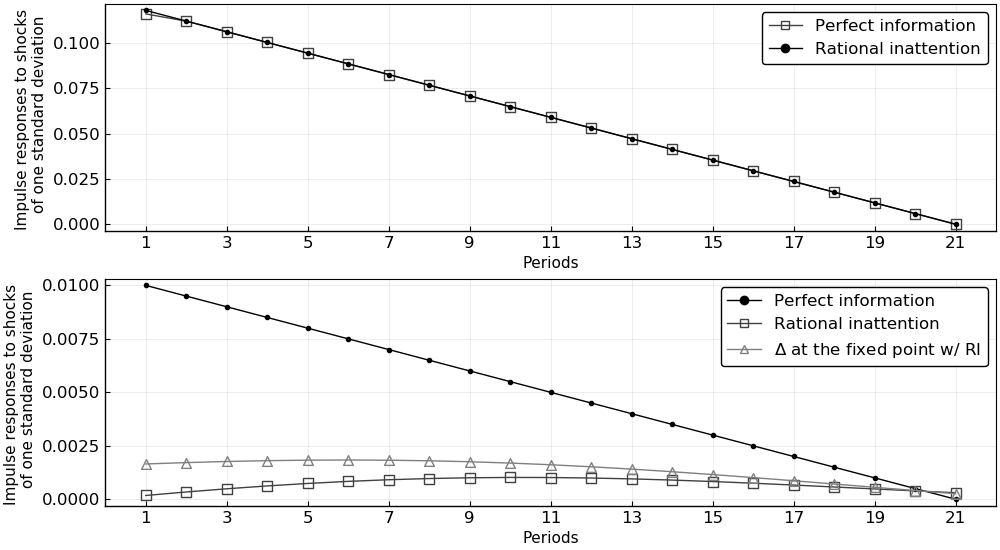

In [6]:
iirfs  = dripirfs(idi,L)
airfs  = dripirfs(agg,L)

p1 = plot([iirfs.a[1,1,:],σz*H],
     label             = ["Perfect information" "Rational inattention"],
     marker            = [:square :circle],
     color             = [:gray25 :black],
     markercolor       = [false :black],
     markerstrokecolor = [:gray25 :black],
     markersize        = [7 3],
     xlabel            = "Periods",
     ylabel            = "Impulse responses to shocks \n of one standard deviation");
p2 = plot([σq*H,airfs.a[1,1,1:end],σq*agg.H],
     label             = ["Perfect information" "Rational inattention" L"$\Delta$ at the fixed point w/ RI"],
     marker            = [:circle :square :utriangle],
     color             = [:black :gray25 :gray50],
     markercolor       = [:black false false] ,
     markerstrokecolor = [:black :gray25 :gray50],
     markersize        = [3 7 7],
     xlabel            = "Periods",
     ylabel            = "Impulse responses to shocks \n of one standard deviation")
    
plot(p1,p2,
    layout     = (2,1),
    xlim       = (0,L+1),
    lw         = 1,
    legend     = :topright,
    legendfont = font(12),
    tickfont   = font(12),
    size       = (1000,550),
    xticks     = 1:2:21,
    framestyle = :box)

### Other values of real rigidity ($\alpha$) <a class="anchor" id="robust_alpha"></a>
$\alpha=0.7$:

In [7]:
ω_α7   = MW(3,0.7,A,Qq,Qz,H,H);
agg_α7 = agg_drip(ω_α7,A,Qq,0.7,H; H0 = rand(L), maxit = 100, w = 0.95);
idi_α7 = solve_drip(ω_α7,1,A,Qz,H,w = 0.9);
@printf("Agg. Capacity = %.2f bits, Idio. Capacity = %.2f bits",capacity(agg_α7),capacity(idi_α7));

ω = 1.00σq² for κ = 3.94 
ω = 2.00σq² for κ = 3.31 
ω = 2.49σq² for κ = 3.11 
ω = 2.78σq² for κ = 3.01 
ω = 2.82σq² for κ = 3.00 
Agg. Capacity = 0.19 bits, Idio. Capacity = 2.81 bits

$\alpha$ = 0:

In [9]:
ω_α0   = MW(3,0,A,Qq,Qz,H,H);
agg_α0 = agg_drip(ω_α0,A,Qq,0,H; H0 = rand(L), maxit = 100, w = 0.95);
idi_α0 = solve_drip(ω_α0,1,A,Qz,H,w = 0.9);
@printf("Agg. Capacity = %.2f bits, Idio. Capacity = %.2f bits",capacity(agg_α0),capacity(idi_α0));

ω = 1.00σq² for κ = 4.16 
ω = 2.00σq² for κ = 3.49 
ω = 2.74σq² for κ = 3.21 
ω = 3.27σq² for κ = 3.05 
ω = 3.44σq² for κ = 3.00 
Agg. Capacity = 0.32 bits, Idio. Capacity = 2.68 bits

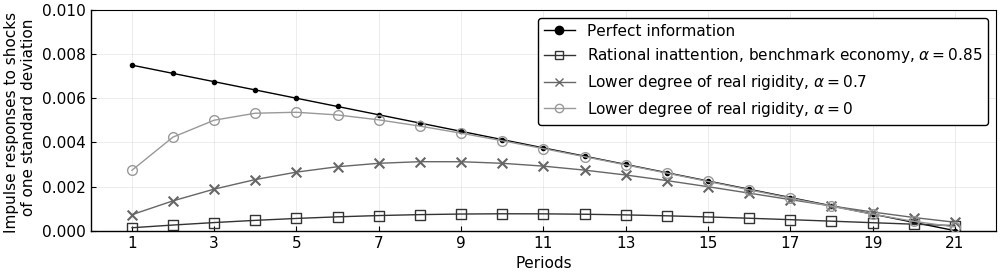

In [10]:
airfs_α7  = dripirfs(agg_α7,L);
airfs_α0  = dripirfs(agg_α0,L);
    
plot(1:L,0.75*[σq*H,airfs.a[1,1,:],airfs_α7.a[1,1,:],airfs_α0.a[1,1,:]],
    label             = ["Perfect information" L"Rational inattention, benchmark economy, $\alpha = 0.85$" L"Lower degree of real rigidity, $\alpha = 0.7$" L"Lower degree of real rigidity, $\alpha = 0$"],
    marker            = [:circle :square :x :circle],
    color             = [:black :gray20 :gray40 :gray60],
    markercolor       = [:black false :gray40 false],
    markerstrokecolor = [:black :gray20 :gray40 :gray60],
    markersize        = [3 7 7 7],
    xlim              = (0,L+1),
    lw                = 1,
    xticks            = 1:2:21,
    legend            = :topright,
    legendfont        = font(11),
    tickfont          = font(11),
    size              = (1000,275),
    ylim              = (0,σq),
    framestyle        = :box,
    xlabel            = "Periods",
    ylabel            = "Impulse responses to shocks \n of one standard deviation")

### Other values of information capacity ($\kappa$) <a class="anchor" id="robust_kappa"></a>
$\kappa=4$:

In [11]:
ω_κ4   = MW(4,α,A,Qq,Qz,H,H);
agg_κ4 = agg_drip(ω_κ4,A,Qq,α,H; H0 = rand(L), maxit = 500, w = 0.95)
idi_κ4 = solve_drip(ω_κ4,1,A,Qz,H,w = 0.9)
@printf("Agg. Capacity = %.2f bits, Idio. Capacity = %.2f bits",capacity(agg_κ4),capacity(idi_κ4));

ω = 1.00σq² for κ = 3.79 
ω = 2.00σq² for κ = 3.14 
ω = 0.69σq² for κ = 4.14 
ω = 0.87σq² for κ = 3.93 
ω = 0.81σq² for κ = 3.99 
ω = 0.80σq² for κ = 4.00 
Agg. Capacity = 0.35 bits, Idio. Capacity = 3.65 bits

$\kappa=5$:

In [12]:
ω_κ5   = MW(5,α,A,Qq,Qz,H,H; ω = 0.1*σq^2);
agg_κ5 = agg_drip(ω_κ5,A,Qq,α,H; H0 = rand(L), maxit = 500, w = 0.95)
idi_κ5 = solve_drip(ω_κ5,1,A,Qz,H,w = 0.9)
@printf("Agg. Capacity = %.2f bits, Idio. Capacity = %.2f bits",capacity(agg_κ5),capacity(idi_κ5));

ω = 0.10σq² for κ = 6.25 
ω = 0.20σq² for κ = 5.41 
ω = 0.25σq² for κ = 5.17 
ω = 0.28σq² for κ = 5.02 
ω = 0.29σq² for κ = 5.02 
ω = 0.31σq² for κ = 4.94 
ω = 0.29σq² for κ = 4.98 
ω = 0.28σq² for κ = 5.02 
ω = 0.29σq² for κ = 5.00 
Agg. Capacity = 0.70 bits, Idio. Capacity = 4.31 bits

Plot:

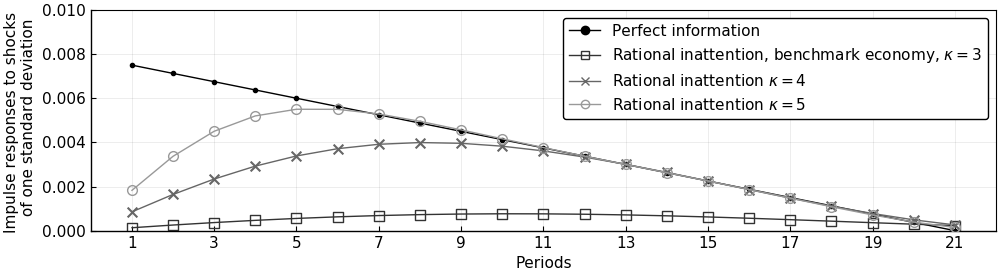

In [13]:
airfs_κ4  = dripirfs(agg_κ4,L);
airfs_κ5  = dripirfs(agg_κ5,L);
    
plot(1:L,0.75*[σq*H,airfs.a[1,1,:],airfs_κ4.a[1,1,:],airfs_κ5.a[1,1,:]],
    label             = ["Perfect information" L"Rational inattention, benchmark economy, $\kappa = 3$" L"Rational inattention $\kappa = 4$" L"Rational inattention $\kappa = 5$"],
    marker            = [:circle :square :x :circle],
    color             = [:black :gray20 :gray40 :gray60],
    markercolor       = [:black false :gray40 false],
    markerstrokecolor = [:black :gray20 :gray40 :gray60],
    markersize        = [3 7 7 7],
    xlim              = (0,L+1),
    lw                = 1,
    xticks            = 1:2:21,
    legend            = :topright,
    legendfont        = font(11),
    tickfont          = font(11),
    size              = (1000,275),
    ylim              = (0,σq),
    framestyle        = :box,
    xlabel            = "Periods",
    ylabel            = "Impulse responses to shocks \n of one standard deviation")

### Measure Performance/Speed <a class="anchor" id="performance"></a>
#### Performance of the code for aggregate problem with feedback

In [14]:
@benchmark agg_drip(ω,A,Qq,α,H; H0 = rand(L), maxit = 100, w = 0.95)

BenchmarkTools.Trial: 
  memory estimate:  932.34 MiB
  allocs estimate:  304711
  --------------
  minimum time:     1.244 s (13.79% GC)
  median time:      1.277 s (13.99% GC)
  mean time:        1.297 s (13.90% GC)
  maximum time:     1.389 s (14.50% GC)
  --------------
  samples:          4
  evals/sample:     1

In [15]:
@benchmark agg_drip(ω_κ5,A,Qq,α,H; H0 = rand(L), maxit = 100, w = 0.95)

BenchmarkTools.Trial: 
  memory estimate:  232.75 MiB
  allocs estimate:  74049
  --------------
  minimum time:     332.931 ms (19.20% GC)
  median time:      400.299 ms (16.14% GC)
  mean time:        417.984 ms (15.33% GC)
  maximum time:     541.684 ms (12.76% GC)
  --------------
  samples:          12
  evals/sample:     1

In [16]:
@benchmark agg_drip(ω_α7,A,Qq,0.7,H; H0 = rand(L), maxit = 100, w = 0.95)

BenchmarkTools.Trial: 
  memory estimate:  127.78 MiB
  allocs estimate:  42240
  --------------
  minimum time:     168.674 ms (12.17% GC)
  median time:      218.269 ms (14.94% GC)
  mean time:        222.348 ms (14.63% GC)
  maximum time:     309.964 ms (12.17% GC)
  --------------
  samples:          23
  evals/sample:     1

#### Performance of the code for idiosyncratic problem

In [17]:
@benchmark solve_drip(ω,1,A,Qz,H,w = 0.9)

BenchmarkTools.Trial: 
  memory estimate:  32.27 MiB
  allocs estimate:  10295
  --------------
  minimum time:     38.934 ms (0.00% GC)
  median time:      45.975 ms (13.20% GC)
  mean time:        45.367 ms (11.11% GC)
  maximum time:     59.634 ms (17.66% GC)
  --------------
  samples:          111
  evals/sample:     1